<a href="https://colab.research.google.com/github/Nsimaar99/Kaggle-Project/blob/master/catiedog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle Library
!pip install --upgrade kaggle


In [ ]:
# Configuring the path to kaggle json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing the dog vs cat dataset from kaggle

In [ ]:
# Kaggle API
!kaggle datasets download -d alvarole/asirra-cats-vs-dogs-object-detection-dataset


Dataset URL: https://www.kaggle.com/datasets/alvarole/asirra-cats-vs-dogs-object-detection-dataset
License(s): other
 83% 20.0M/24.2M [00:00<00:00, 38.2MB/s]
100% 24.2M/24.2M [00:00<00:00, 39.7MB/s]


In [ ]:
!ls


asirra-cats-vs-dogs-object-detection-dataset.zip  dogoo.jpg  kaggle.json  sample_data


In [ ]:
# Extracting the dataset
from zipfile import ZipFile
dataset = '/content/asirra-cats-vs-dogs-object-detection-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')


The dataset is extracted


In [ ]:
import os

# Path to the extracted dataset directory
extracted_dir = '/content/Asirra: cat vs dogs'

# Counting the number of files in the dataset directory and subdirectories
file_count = 0
for root, dirs, files in os.walk(extracted_dir):
    file_count += len(files)

print(f'Total number of files in the dataset: {file_count}')



Total number of files in the dataset: 2200


In [ ]:
import os
import shutil

# Define the dataset directory
data_dir = '/content/Asirra: cat vs dogs'
cats_dir = os.path.join(data_dir, 'cats')
dogs_dir = os.path.join(data_dir, 'dogs')

# Create subfolders for 'cats' and 'dogs'
os.makedirs(cats_dir, exist_ok=True)
os.makedirs(dogs_dir, exist_ok=True)

# Iterate over all files in the dataset directory
for filename in os.listdir(data_dir):
    # Check if the item is a file and not a directory
    if os.path.isfile(os.path.join(data_dir, filename)):
        if filename.lower().startswith('cat'):
            # Move cat images to 'cats/' folder
            shutil.move(os.path.join(data_dir, filename), os.path.join(cats_dir, filename))
        elif filename.lower().startswith('dog'):
            # Move dog images to 'dogs/' folder
            shutil.move(os.path.join(data_dir, filename), os.path.join(dogs_dir, filename))

print(f"Images have been moved to 'cats/' and 'dogs/' folders.")


Images have been moved to 'cats/' and 'dogs/' folders.


In [ ]:
import os

# Define paths to the Cat and Dog directories
cat_dir = '/content/Asirra: cat vs dogs/cats'
dog_dir = '/content/Asirra: cat vs dogs/dogs'

# Count the number of images in each directory
num_cats = len(os.listdir(cat_dir))
num_dogs = len(os.listdir(dog_dir))

print(f'Number of Cat images: {num_cats}')
print(f'Number of Dog images: {num_dogs}')

# Check balance
if num_cats > num_dogs:
    print(f"There are more Cat images. Difference: {num_cats - num_dogs}")
elif num_dogs > num_cats:
    print(f"There are more Dog images. Difference: {num_dogs - num_cats}")
else:
    print("The dataset is balanced.")


Number of Cat images: 1100
Number of Dog images: 1100
The dataset is balanced.


Classes: ['cats', 'dogs']


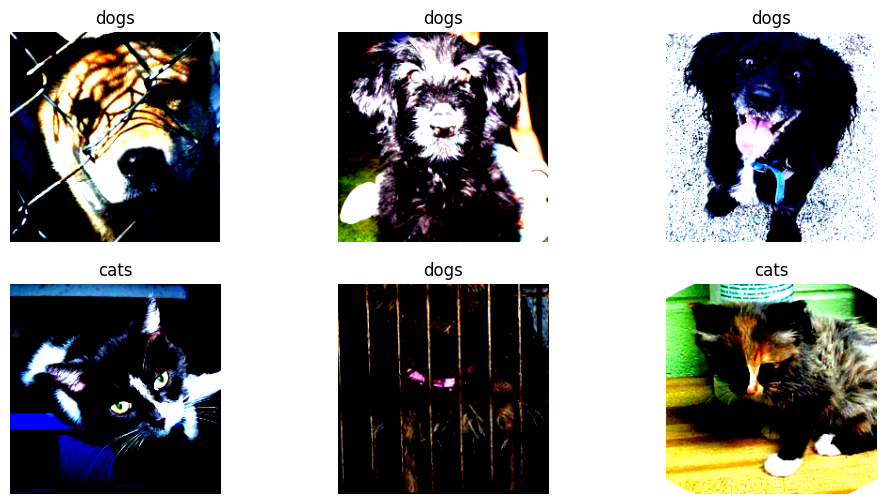

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define data augmentation and normalization for the training set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop for data augmentation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet standards
])

# Define normalization only for the validation and test sets (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize(256),  # Resize to 256 pixels for consistent input
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet standards
])

# Load the dataset
data_dir = '/content/Asirra: cat vs dogs'
dataset = datasets.ImageFolder(root=data_dir)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the appropriate transforms to each dataset
train_dataset.dataset.transform = train_transforms  # Apply augmentation to the training set
val_dataset.dataset.transform = test_transforms  # Apply only normalization to the validation set
test_dataset.dataset.transform = test_transforms  # Apply only normalization to the test set

# Create DataLoaders for each dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check class-to-index mapping (same for all splits since it's the same dataset)
class_names = dataset.classes
print(f'Classes: {class_names}')

# Function to visualize some images from the training set
def visualize_samples(loader):
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))  # Convert from tensor format
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

# Visualize a few samples from the training set
visualize_samples(train_loader)



In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers in the model (optional, for fine-tuning only the last layers)
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer: input layer + 3 hidden layers + output layer
num_classes = 2  # Cats and Dogs (2 classes)
model.fc = nn.Sequential(
    # Input layer (using the input features from ResNet50)
    nn.Linear(model.fc.in_features, 1024),  # First hidden layer with 1024 neurons
    nn.ReLU(),  # Activation function

    # Hidden Layer 1
    nn.Linear(1024, 512),  # Second hidden layer with 512 neurons
    nn.ReLU(),  # Activation function
    nn.Dropout(0.5),  # Dropout for regularization (optional)

    # Hidden Layer 2
    nn.Linear(512, 256),  # Third hidden layer with 256 neurons
    nn.ReLU(),  # Activation function
    nn.Dropout(0.5),  # Dropout for regularization (optional)

    # Hidden Layer 3
    nn.Linear(256, 128),  # Fourth hidden layer with 128 neurons
    nn.ReLU(),  # Activation function
    nn.Dropout(0.5),  # Dropout for regularization (optional)

    # Output Layer
    nn.Linear(128, num_classes)  # Output layer with 2 neurons (one for each class)
    # Note: No LogSoftmax here; CrossEntropyLoss will handle this.
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example of defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for classification

# Using SGD optimizer with learning rate 0.001 and momentum 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/10: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


Epoch [1/10], Training Loss: 0.6937, Training Accuracy: 0.4987
Validation Loss: 0.6924, Validation Accuracy: 0.5152


Training Epoch 2/10: 100%|██████████| 25/25 [00:05<00:00,  4.64it/s]


Epoch [2/10], Training Loss: 0.6932, Training Accuracy: 0.5039
Validation Loss: 0.6921, Validation Accuracy: 0.5152


Training Epoch 3/10: 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Epoch [3/10], Training Loss: 0.6921, Training Accuracy: 0.5299
Validation Loss: 0.6921, Validation Accuracy: 0.5152


Training Epoch 4/10: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


Epoch [4/10], Training Loss: 0.6926, Training Accuracy: 0.5247
Validation Loss: 0.6922, Validation Accuracy: 0.5152


Training Epoch 5/10: 100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


Epoch [5/10], Training Loss: 0.6937, Training Accuracy: 0.5013
Validation Loss: 0.6921, Validation Accuracy: 0.5212


Training Epoch 6/10: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]


Epoch [6/10], Training Loss: 0.6935, Training Accuracy: 0.4818
Validation Loss: 0.6921, Validation Accuracy: 0.5212


Training Epoch 7/10: 100%|██████████| 25/25 [00:05<00:00,  4.31it/s]


Epoch [7/10], Training Loss: 0.6927, Training Accuracy: 0.5273
Validation Loss: 0.6921, Validation Accuracy: 0.5212


Training Epoch 8/10: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


Epoch [8/10], Training Loss: 0.6926, Training Accuracy: 0.5078
Validation Loss: 0.6920, Validation Accuracy: 0.5212


Training Epoch 9/10: 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch [9/10], Training Loss: 0.6934, Training Accuracy: 0.5013
Validation Loss: 0.6921, Validation Accuracy: 0.5212


Training Epoch 10/10: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]


Epoch [10/10], Training Loss: 0.6919, Training Accuracy: 0.5377
Validation Loss: 0.6920, Validation Accuracy: 0.5212


In [ ]:
# Assuming test_loader is defined and available

# Testing phase
model.eval()  # Set the model to evaluation mode
test_running_loss = 0.0
test_correct = 0
test_total = 0

# Disable gradient calculation for testing
with torch.no_grad():
    for images, labels in test_loader:  # Loop through test data
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        test_running_loss += loss.item() * images.size(0)  # Accumulate test loss
        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        test_total += labels.size(0)  # Total number of samples
        test_correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate average test loss and accuracy
test_epoch_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_epoch_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}')




Test Loss: 0.6921, Test Accuracy: 0.4788


In [ ]:
# Save the model
torch.save(model.state_dict(), 'resnet50_model.pth')

In [ ]:
# Load the model
model.load_state_dict(torch.load('resnet50_model.pth'))

<ipython-input-38-8f8f5282b401>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_model.pth'))


<All keys matched successfully>

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from torchvision import transforms

# Load the pre-trained ResNet50 model with the modified classifier
class MyResNetModel(nn.Module):
    def __init__(self):
        super(MyResNetModel, self).__init__()
        self.model = models.resnet50(pretrained=True)  # Load pre-trained ResNet50
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Modify the fully connected layer
        num_classes = 2  # Cats and Dogs
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)  # No LogSoftmax
        )

    def forward(self, x):
        return self.model(x)

# Load the model
model = MyResNetModel()

# Load the state dictionary with the 'strict=False' argument
# This will load only the matching keys and ignore the missing/unexpected ones.
model.load_state_dict(torch.load('/content/resnet50_model.pth'), strict=False)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)




<ipython-input-39-c56f2b9c3eef>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/resnet50_model.pth'), strict=False)


MyResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
def load_image(image_path, device):
    img = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor.to(device)  # Move to GPU if necessary

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Convert PyTorch tensor to NumPy array and re-arrange dimensions
    image = image.cpu().numpy().transpose((1, 2, 0))  # Move to CPU if needed
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Re-normalize for display
    image = np.clip(image, 0, 1)  # Clip values to valid range [0,1]
    ax.imshow(image)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to predict the class of an image and show top K predictions
def predict(image_path, model, topk=1):
    # Define class_to_name here
    class_to_name = {0: 'Cat', 1: 'Dog'}  # Assuming 0 is for Cat and 1 is for Dog

    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    # Pass the 'device' argument to load_image
    image = load_image(image_path, device)
    image = image.to(device)  # Ensure image is on the same device as the model

    # Perform prediction
    with torch.no_grad():  # Disable gradients for inference
        output = model(image)  # Get model logits
        probabilities = F.softmax(output, dim=1)  # Apply softmax to convert logits to probabilities
        top_p, top_class = probabilities.topk(topk, dim=1)  # Get top-K predictions

    # Convert class indices to class names
    top_p = top_p.cpu().numpy().flatten()  # Convert to numpy array for easy handling
    top_class = top_class.cpu().numpy().flatten()  # Convert to numpy array
    top_class_names = [class_to_name[cls] for cls in top_class]  # Map indices to "Dog" or "Cat"

    # Display the image with the top-1 class prediction as title
    image_for_display = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    imshow(load_image(image_path, device).squeeze())  # Show the image without batch dimension # Pass the 'device' argument to load_image
    plt.title(f"Predicted: {top_class_names[0]} ({top_p[0]:.4f})")
    plt.show()

    # Print out the top K classes with their probabilities
    print("Top Predictions:")
    for i in range(topk):
        print(f"{i+1}. {top_class_names[i]} - Confidence: {top_p[i]:.4f}")

    return top_class_names, top_p  # Return class names and probabilities


<Figure size 600x600 with 0 Axes>

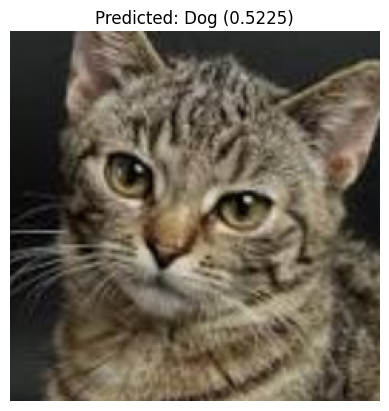

Top Predictions:
1. Dog - Confidence: 0.5225


In [ ]:
# Example usage
image_path = '/content/catton.jpg'  # Replace with your image path
predicted_class_names, confidences = predict(image_path, model)